## INSY 695: End-to-End Machine Learning Project -- Heart Disease Prediction
### Duncan Wang

In [474]:
#import relevant libraries 
import pandas as pd 
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

## 1. Get Data

- Original Data Source: 
    - 1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    - 2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    - 3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    - 4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.
    - https://archive.ics.uci.edu/ml/datasets/Heart+Disease
- Permissions: Open source, data has been anonymized, no sensitive information included

In [525]:
import requests 

#read file from data source and open as csv
req = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data')
url_content = req.content
csv_file = open('heart-data.csv', 'wb')
csv_file.write(url_content)
csv_file.close()

#assign to new df with original column names from data source 
df = pd.read_csv('heart-data.csv', 
                 names = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','condition'])

#rename columns into more intuitive names for ease of comprehension 
df.rename(columns ={'cp':'chest_pain','trestbps':'rest_bp','chol':'cholesterol','fbs':'fast_bs',
                    'restecg':'rest_ecg','thalach':'max_hr','exang':'exercise_angina','oldpeak':'st_depression',
                    'slope':'st_slope', 'ca':'blocked_vessels','thal':'thalassemia_type','condition':'heart_disease'}, inplace = True)
#view the data 
df.head(3)

,age,sex,chest_pain,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,blocked_vessels,thalassemia_type,heart_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1


## 2. Data Description

**Attribute Descriptions (from source)**
- **age**: age of the patient
- **sex**: sex of the patient (1 = male, 0 = female) 
- **chest_pain**: pain level between 1-4, higher number = lower odds of heart attack (1= typical, 2 = atypical, 3 = non-anginal pain, 4 = asymptomatic) 
- **rest_bp**: resting blood pressure (in mm HG on admission) 
- **cholesterol**: serum cholesterol in mg/dl, higher = higher odds of heart attack 
- **fast_bs**: fasting blood sugar > 120 mg/dl (1 = true, 0 = false), indicative of diabetes 
- **rest_ecg**: resting electrocardiographic results (0 = normal, 1 = ST wave abnormality, 2 = left ventricular hypertrophy)
- **max_hr**: max heart rate achieved 
- **exercise_angina**: exercised induced angina, or chest pain, (1 = yes, 0 = no) 
- **st_depression**: difference in ECG value at rest vs. after exercise, measured as an ST depression 
- **st_slope**: slope/tangent of the peak ST depression segment (1 = upsloping, 2 = flat, 3 = downsloping) 
- **blocked_vessels**: number of blocked heart vessels (0-3) 
- **thalassemia_type**: types of thalassemia, an inherited blood disorder which inhibits hemoglobin, (3 = normal; 6 = fixed defect; 7 = reversable defect) 
- **heart_disease (target)**: 0 = absence, 1,2,3,4 = some degree of presence

**Generate Descriptive Statistics**

A comprehensive set of descriptive statistics can be generated via pandas profiling. Alternatively, variable distributions, dataset size, and null values can also be examined via other tools below.

In [526]:
#generate descriptive statistics via pandas profiling 

profile = df.profile_report(title = 'Pandas Profiling Report')
profile.to_file(output_file = 'pandas_profile_report.html')

In [527]:
#generate descriptive statistics 
df.describe()

,age,sex,chest_pain,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,heart_disease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


**Examine Data Type and Size**

In [528]:
#all data in numerical type, dataset is small enough to work with easily
df.info()
print('Number of rows in the dataset: ',df.shape[0])
print('Number of columns in the dataset: ',df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               303 non-null    float64
 1   sex               303 non-null    float64
 2   chest_pain        303 non-null    float64
 3   rest_bp           303 non-null    float64
 4   cholesterol       303 non-null    float64
 5   fast_bs           303 non-null    float64
 6   rest_ecg          303 non-null    float64
 7   max_hr            303 non-null    float64
 8   exercise_angina   303 non-null    float64
 9   st_depression     303 non-null    float64
 10  st_slope          303 non-null    float64
 11  blocked_vessels   303 non-null    object 
 12  thalassemia_type  303 non-null    object 
 13  heart_disease     303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
Number of rows in the dataset:  303
Number of columns in the dataset:  14


**Check for Missing Values**

In [529]:
#check for null values -- no null values
df.isnull().any()

age                 False
sex                 False
chest_pain          False
rest_bp             False
cholesterol         False
fast_bs             False
rest_ecg            False
max_hr              False
exercise_angina     False
st_depression       False
st_slope            False
blocked_vessels     False
thalassemia_type    False
heart_disease       False
dtype: bool

## 3. Split Data

The dataset is split into training and test sets before conducting exploratory data analysis to prevent data leakage -- since visualizing the "future data" could wrongfully influence decisions to manipulate the dataset.

In [530]:
#split train and test data
#since the datset is small, stratify by the target to ensure that 30% of each class of target variable end up in test set 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3, random_state = 13, stratify = df['heart_disease'])

#view dataset sizes 
print(train.shape, test.shape)

(212, 14) (91, 14)


## 4. Exploratory Data Analysis (EDA)

Exploratory data analysis is conducted only using the training dataset. Broadly, the variables to explore can be broken down into continuous and categorical.

**Continuous Variables**
- age
- rest_bp
- cholesterol
- max_hr
- st_depression

**Categorical Variables**
- sex
- chest_pain
- fast_bs
- rest_ecg
- exercise_angina
- st_slope
- blocked_vessels
- thalassemia_type
- heart_condition (TARGET)

**Check for Correlation** 

Only correlation between continuous variables needs to be examined. There are no highly correlated variables to be concerned about in this case.

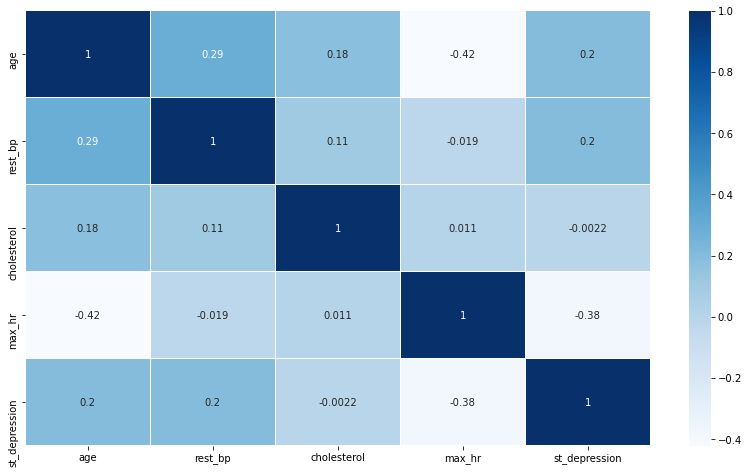

In [531]:
corr_continuous = train[['age', 'rest_bp','cholesterol','max_hr','st_depression']]

plt.figure(figsize=(14,8))
sns.heatmap(corr_continuous.corr(), annot = True, cmap="Blues", linewidths=.1)
plt.show()

**Histograms**

Histograms can be used in this case to visualize both continuous variables and categorical variables, to see the distribution of continuous variables and the relative frequencies of observations in each categorical class.

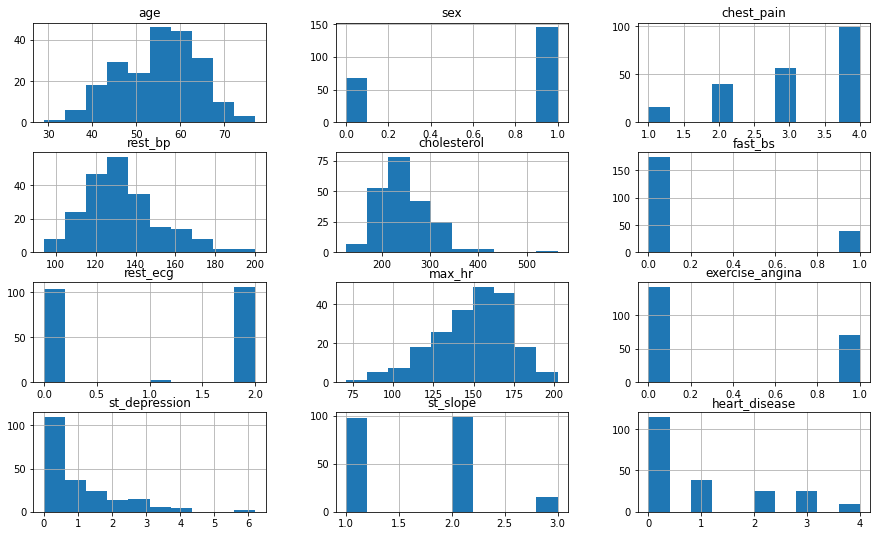

In [532]:
train.hist(bins=10, figsize=(15,9))
plt.show()

**Variable Relationships**

Examine the relationship between, the target variable -- heart disease, and continuous variables, and examine how patterns differ based on age, and sex. We see that cholesterol levels tend to rise amongst females more than males with older age, and heart rate tends to decrease with age. There does not appear to be any obvious relationships between heart disease and any variables from these graphs.

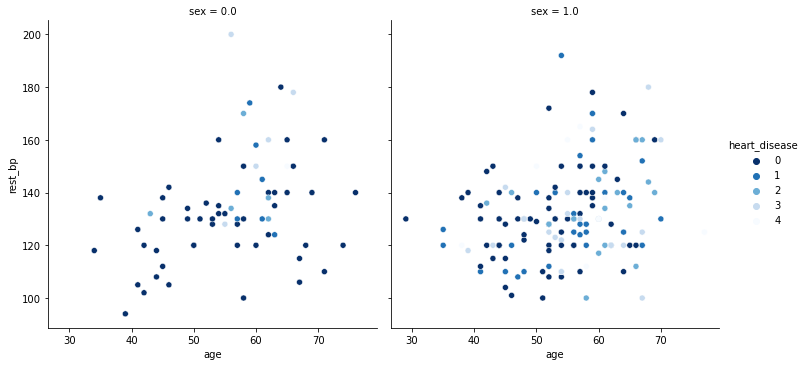

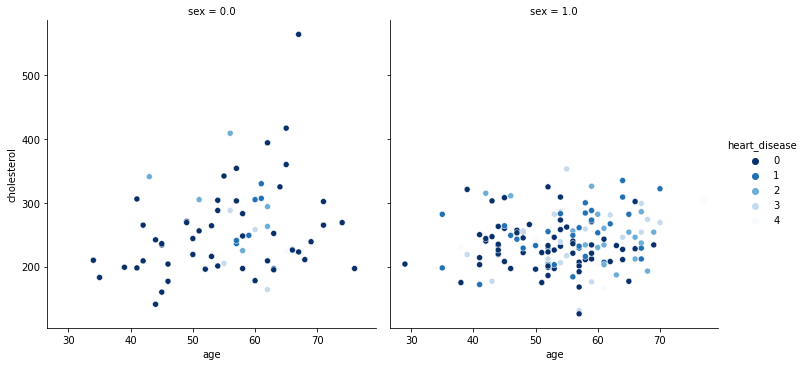

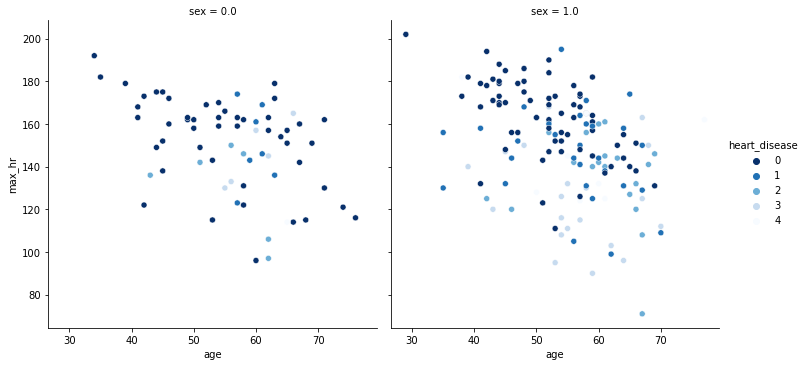

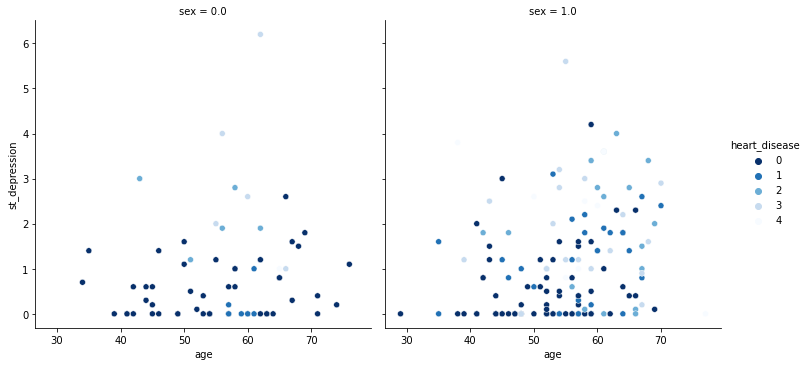

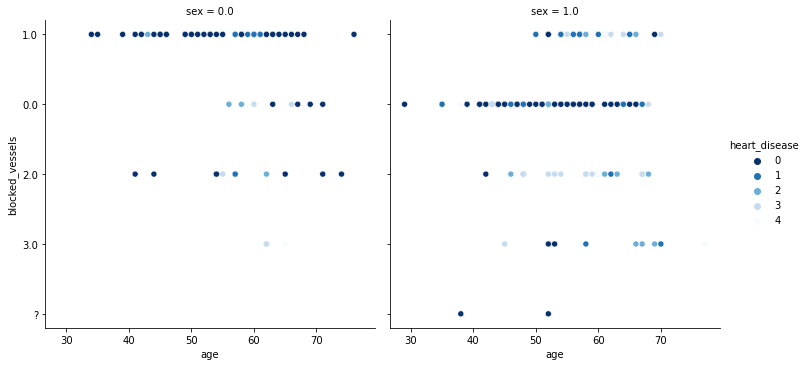

In [533]:
#visualize continuous variables by age, sex, and heart condition (target)
sns.relplot(x ='age', y ='rest_bp', hue = 'heart_disease', col = 'sex', data = train, palette = 'Blues_r')
sns.relplot(x ='age', y ='cholesterol', hue = 'heart_disease', col = 'sex', data = train, palette = 'Blues_r')
sns.relplot(x ='age', y ='max_hr', hue = 'heart_disease', col = 'sex', data = train, palette = 'Blues_r')
sns.relplot(x ='age', y ='st_depression', hue = 'heart_disease', col = 'sex', data = train, palette = 'Blues_r')
sns.relplot(x ='age', y ='blocked_vessels', hue = 'heart_disease', col = 'sex', data = train, palette = 'Blues_r')

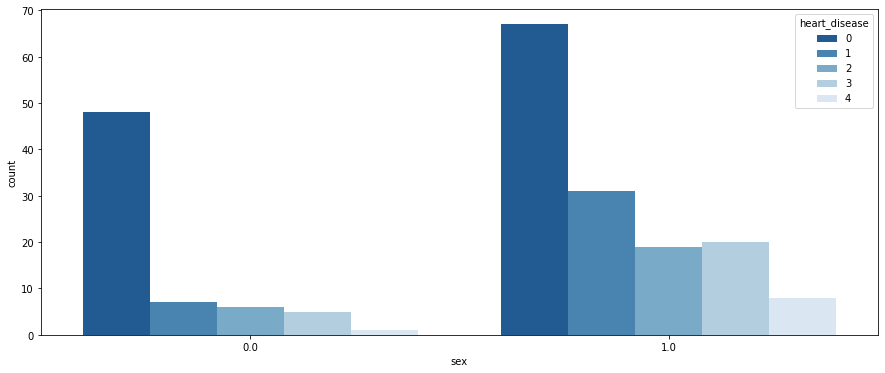

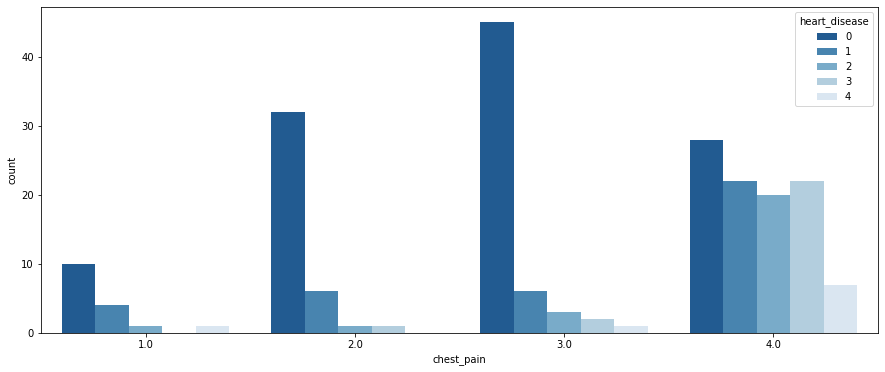

In [556]:
#heart disease by sex 
plt.figure(figsize=(15,6))
sns.countplot(x='sex',data = train, hue = 'heart_disease',palette='Blues_r')

#heart disease by chest pain 
plt.figure(figsize=(15,6))
sns.countplot(x='chest_pain',data = train, hue = 'heart_disease',palette='Blues_r')
plt.show()

**Paired Relationships**

Anything else missed can be visualized below. Click on plot to zoom.

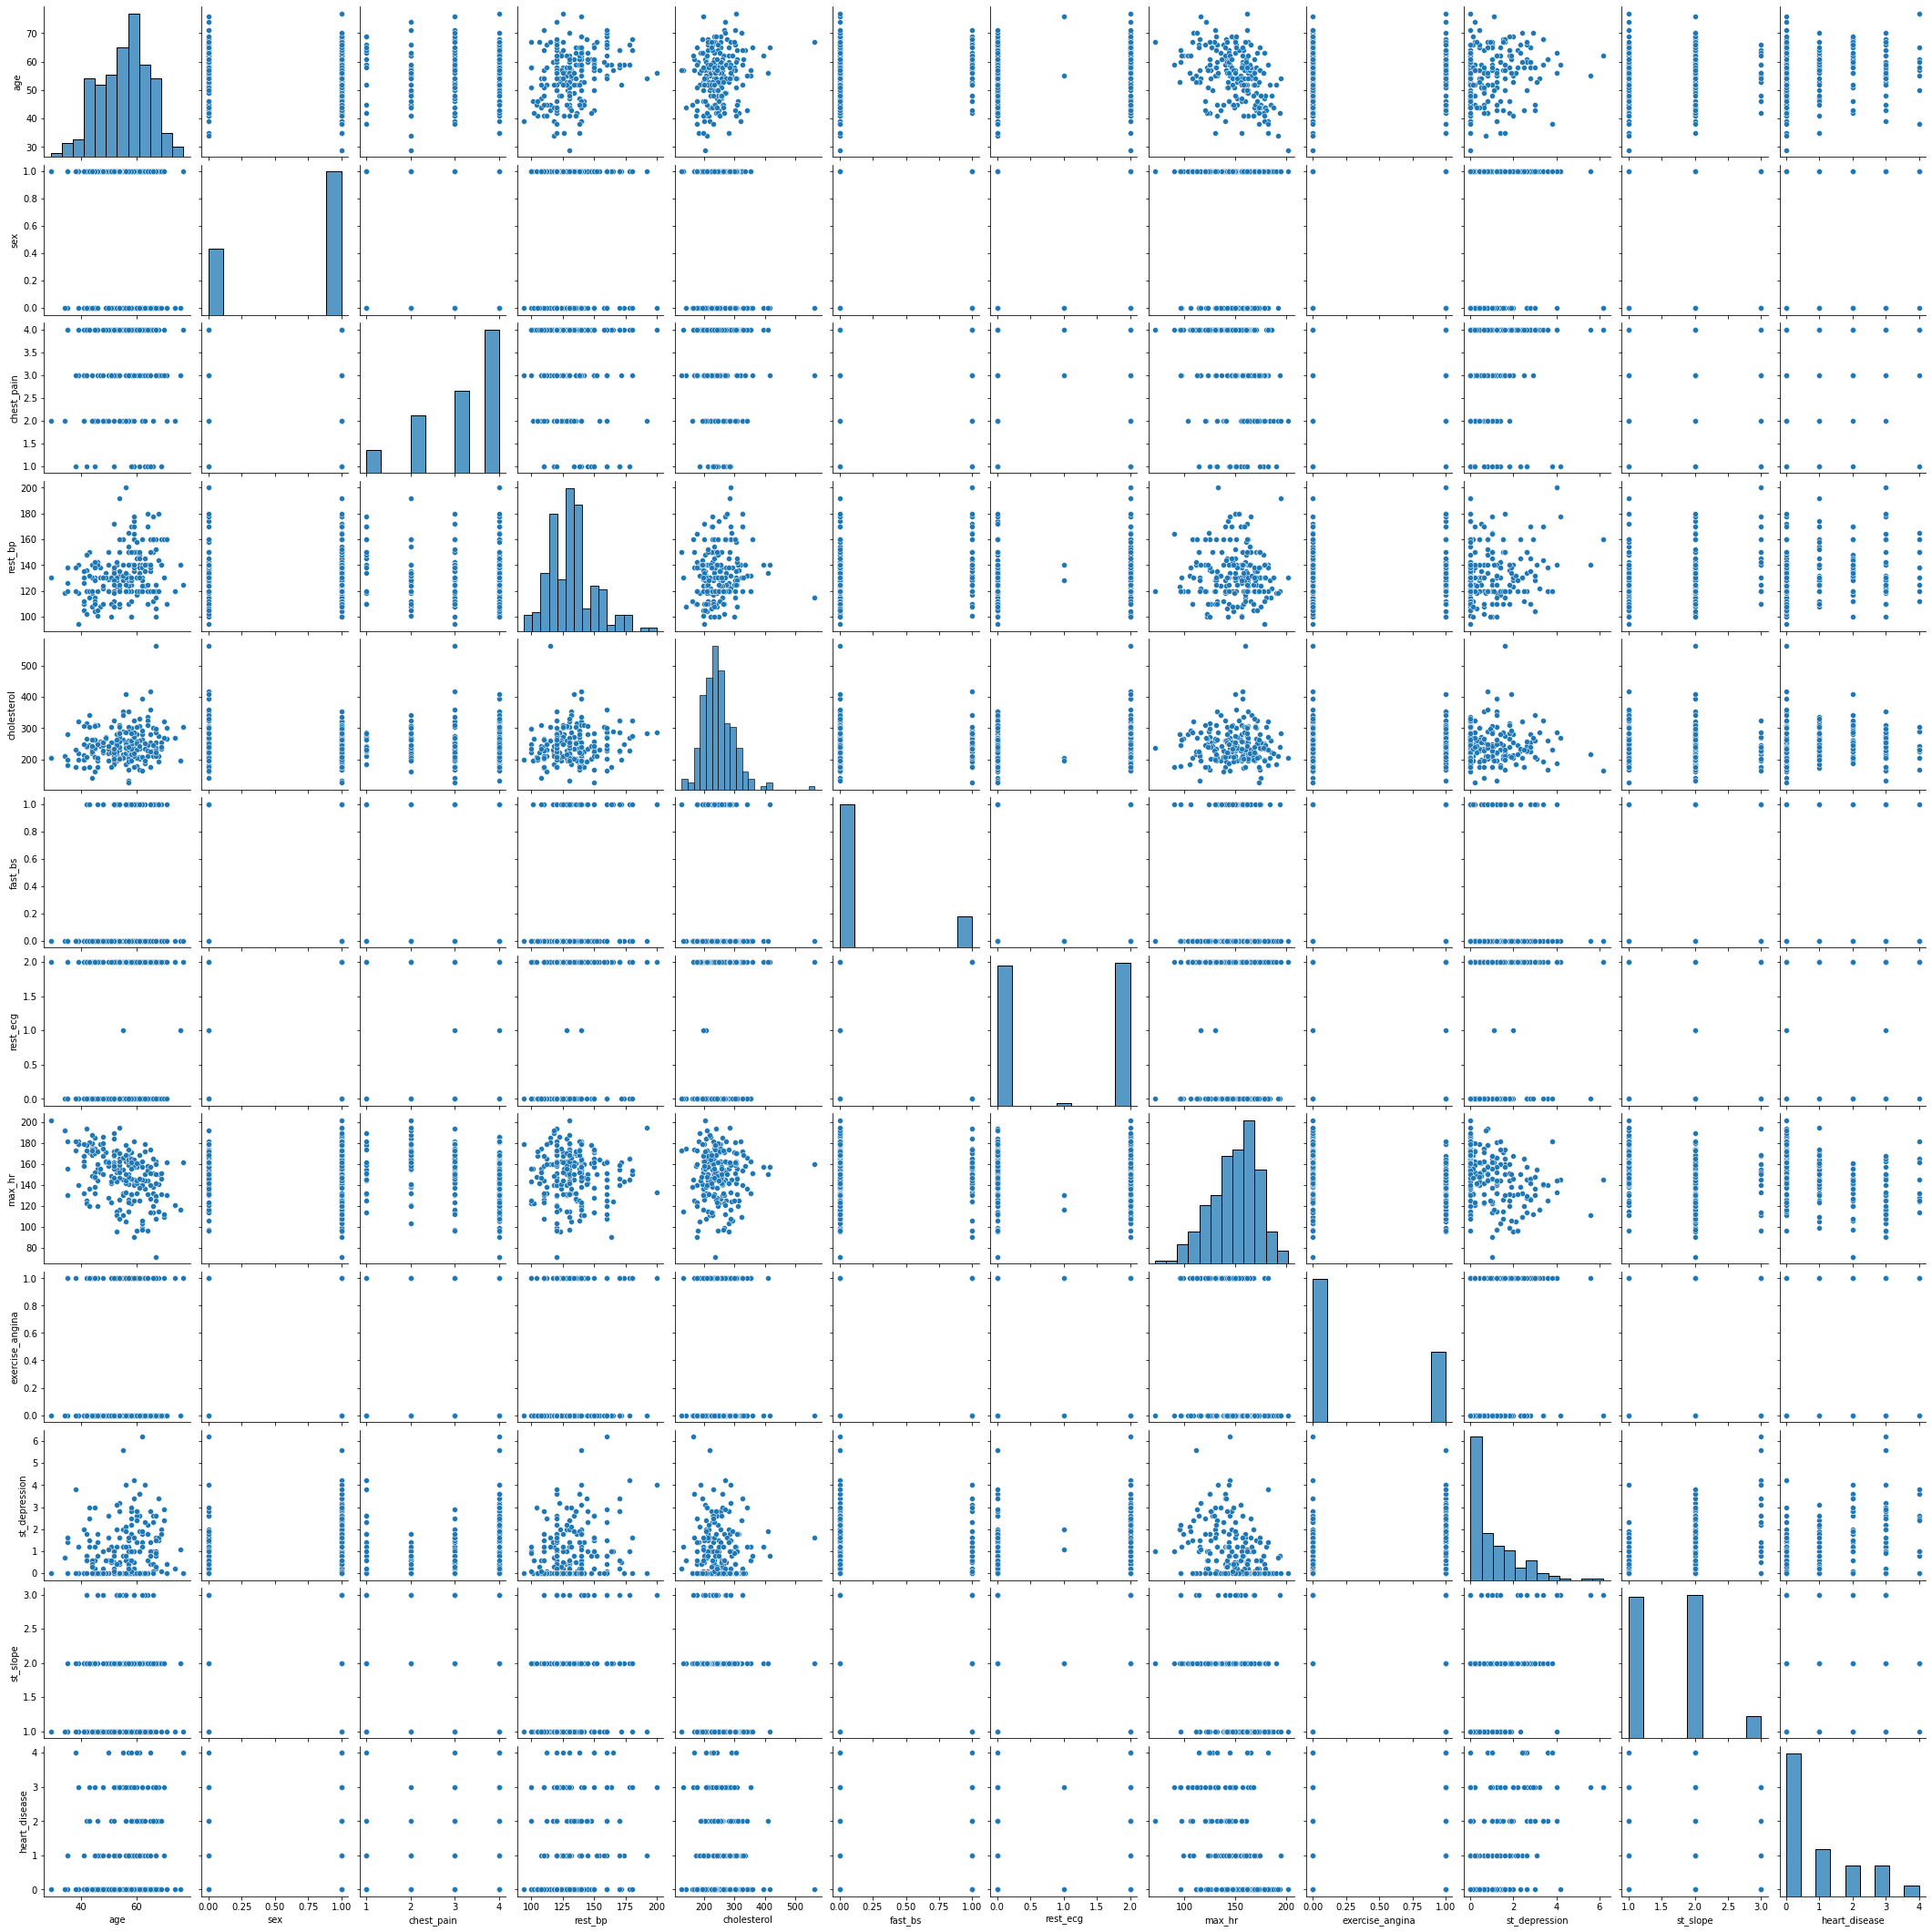

In [492]:
#plot paired relationships -- this gives a summary of everything the previous graphs did not capture
sns.pairplot(train,  palette = 'Blues')
plt.show()

**Outlier Detection**

In [557]:
#use isolation forest to examine most extreme 2.5% of outliers from continuous variables from the analysis, which were visually identified during data exploration

continuous_vars = train[['age','sex','rest_bp','cholesterol','max_hr','st_depression']]

from sklearn.ensemble import IsolationForest
iforest = IsolationForest(n_estimators = 100,random_state=13, contamination=0.025) 

#predict anomalies
pred = iforest.fit_predict(continuous_vars)
#anomaly score of each 
iforest_scores = iforest.decision_function(continuous_vars)

#create a new variable to store the index number where anomaly =-1 in the anomalies vector
from numpy import where
anomaly_index = where(pred ==-1)
#extract values corresponding to the index of anomalies from the main df
anomaly_values = train.iloc[anomaly_index]
anomaly_values

#since our dataset is small, choose to keep the outliers and see how the model performs 

,age,sex,chest_pain,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,blocked_vessels,thalassemia_type,heart_disease
152,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
132,29.0,1.0,2.0,130.0,204.0,0.0,2.0,202.0,0.0,0.0,1.0,0.0,3.0,0
126,56.0,0.0,4.0,200.0,288.0,1.0,2.0,133.0,1.0,4.0,3.0,2.0,7.0,3
211,38.0,1.0,1.0,120.0,231.0,0.0,0.0,182.0,1.0,3.8,2.0,0.0,7.0,4
113,43.0,0.0,4.0,132.0,341.0,1.0,2.0,136.0,1.0,3.0,2.0,0.0,7.0,2
91,62.0,0.0,4.0,160.0,164.0,0.0,2.0,145.0,0.0,6.2,3.0,3.0,7.0,3


## 5. Data Preparation 

**Impute Null Values**

From examining the pandas profile report, it can be seen that though there are no null values, there are values coded as '?'. Furthermore, the documentation states that thalassemia type 5 should be also NaN. These values are imputed using the most common group, since they are categorical.

In [558]:
#from the pandas profiling report we see that there are null values which are '?' in two columns 
df[df['blocked_vessels'] == '?']
df[df['thalassemia_type'] == '?']

#thus, replace null values in the train and test sets 
train['blocked_vessels'].replace('?', np.NaN, inplace = True)
train['thalassemia_type'].replace(['?',5], np.NaN, inplace = True)
test['blocked_vessels'].replace('?', np.NaN, inplace = True)
test['thalassemia_type'].replace(['?',5], np.NaN, inplace = True)

#use simple imputer to impute null values 
from sklearn.impute import SimpleImputer
#impute by mode, since the missing values are categorical
cols = df.columns 
imputer = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imputed = imputer.fit_transform(train[cols])
train.loc[:,cols] = imputed
imputed = imputer.transform(test[cols])
test.loc[:,cols] = imputed

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

**Recode Variables for Classification**

Recode categorical variables to lie on a scale from 0+, for the sake of consistency. The target is also grouped into fewer classes for binary classification of heart disease (1,2,3,4), or no heart disease (0), according to the data documentation.

In [559]:
categorical = ['sex','chest_pain','fast_bs','rest_ecg','exercise_angina','st_slope','blocked_vessels','thalassemia_type','heart_disease']

train[categorical] = train[categorical].astype(str).astype(float).astype(int)
test[categorical] = test[categorical].astype(str).astype(float).astype(int)

#regroup target into binary -- 1,2,3,4 = some heart disease, 0 = none 
train['heart_disease'].replace([1,2,3,4],1, inplace = True)
test['heart_disease'].replace([1,2,3,4],1, inplace = True)

#recode other categorical variables on a consistent scale starting from 0
train['chest_pain'] = train['chest_pain'] - 1
test['chest_pain'] = test['chest_pain'] - 1

train['st_slope'] = train['st_slope'] - 1
test['st_slope'] = test['st_slope'] - 1

train['thalassemia_type'].replace(3,0, inplace = True)
train['thalassemia_type'].replace(6,1, inplace = True)
train['thalassemia_type'].replace(7,2, inplace = True)
test['thalassemia_type'].replace(3,0, inplace = True)
test['thalassemia_type'].replace(6,1, inplace = True)
test['thalassemia_type'].replace(7,2, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [560]:
#now the target is relatively balanced as well 
train['heart_disease'].value_counts()

0    115
1     97
Name: heart_disease, dtype: int64

**Feature Selection**

Feature selection for categorical variables is done using chi-squared tests of independence, since the target is also categorical. For variables with more than 2 classes that are assessed as significant at a level of 0.05, perform perform bonferroni adjusted pair-wise comparisons as post-hoc tests to see which specific levels of the significant variables are significantly related to the target.

In [496]:
from scipy.stats import chi2_contingency

#perform chi-squared tests on categorical variables
categorical_columns = ['sex','chest_pain','fast_bs','rest_ecg','exercise_angina','st_slope','blocked_vessels','thalassemia_type']
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(train['heart_disease'], train[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_columns, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
res

,Column,Hypothesis
0,sex,Reject Null Hypothesis
1,chest_pain,Reject Null Hypothesis
2,fast_bs,Fail to Reject Null Hypothesis
3,rest_ecg,Fail to Reject Null Hypothesis
4,exercise_angina,Reject Null Hypothesis
5,st_slope,Reject Null Hypothesis
6,blocked_vessels,Reject Null Hypothesis
7,thalassemia_type,Reject Null Hypothesis


In [497]:
#select only columns which have more than 2 categories for pairwise comparisons 
res = res.loc[[1,6,7],:]

check = {}
for i in res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']:
    dummies = pd.get_dummies(train[i])
    bon_p_value = 0.05/train[i].nunique()
    for series in dummies:
        if chi2_contingency(pd.crosstab(train['heart_disease'], dummies[series]))[1] < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'
res_chi = pd.DataFrame(data = [check.keys(), check.values()]).T
res_chi.columns = ['Pair', 'Hypothesis']

#create a new list with significant facotrs to subset original dataset by
significant_chi = []
for i in res_chi[res_chi['Hypothesis'] == 'Reject Null Hypothesis']['Pair']:
    significant_chi.append('{}_{}'.format(i.split('-')[0],i.split('-')[1]))
significant_chi

['chest_pain_1',
 'chest_pain_2',
 'chest_pain_3',
 'blocked_vessels_0',
 'blocked_vessels_1',
 'blocked_vessels_2',
 'blocked_vessels_3',
 'thalassemia_type_0',
 'thalassemia_type_2']

**Categorical Encoding**

In [498]:
#one-hot encode significant categorical variables from chi2 and join to continuous variables
#ensure that significant categorical variables with only 2 classes are not dummified
train_dummies = pd.get_dummies(data = train, columns = ['chest_pain','blocked_vessels','thalassemia_type'])
train_dummies = train_dummies[significant_chi]
train = train[['age','sex','rest_bp','cholesterol','max_hr','exercise_angina','st_depression','st_slope','heart_disease']].join(train_dummies)

#apply process for test data using significant variables from train data 
test_dummies = pd.get_dummies(data = test, columns = ['chest_pain','blocked_vessels','thalassemia_type'])
test_dummies = test_dummies[significant_chi]
test = test[['age','sex','rest_bp','cholesterol','max_hr','exercise_angina','st_depression','st_slope','heart_disease']].join(test_dummies)

**Split Predictors from Target**

In [499]:
X_train = train.drop('heart_disease', axis = 1)
y_train = train['heart_disease']

X_test = test.drop('heart_disease', axis = 1)
y_test = test['heart_disease']

**Scale Features**

In [500]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled)

## 6. Model Building and Comparison

**Compare All Models Using K-Folds:** 
Use 10-folds cross validation to compare accuracy, precision, and recall amongst models for a baseline comparison. It roughly appears that KNN performs the best, followed by Logistic Regression.

accuracy
LR: 0.849351 (0.058114)
KNN: 0.867965 (0.063031)
DT: 0.726840 (0.095517)
RF: 0.825541 (0.070239)
GB: 0.797619 (0.068934)
MLP: 0.820996 (0.089150)
SVC: 0.849351 (0.058114)


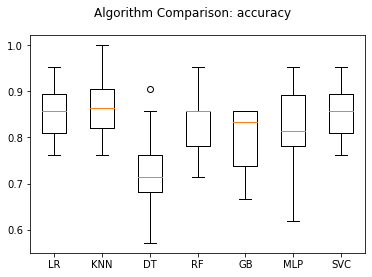

recall
LR: 0.815177 (0.091148)
KNN: 0.827399 (0.115012)
DT: 0.679116 (0.139000)
RF: 0.789924 (0.113198)
GB: 0.778813 (0.110430)
MLP: 0.794066 (0.104328)
SVC: 0.815177 (0.091148)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


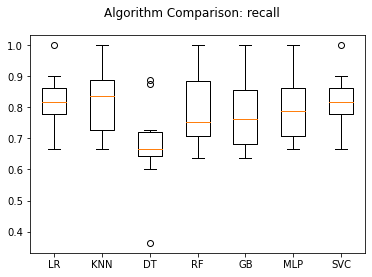

precision
LR: 0.857096 (0.109018)
KNN: 0.886944 (0.087595)
DT: 0.718838 (0.103304)
RF: 0.831944 (0.099654)
GB: 0.786061 (0.091934)
MLP: 0.822126 (0.111533)
SVC: 0.857096 (0.109018)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


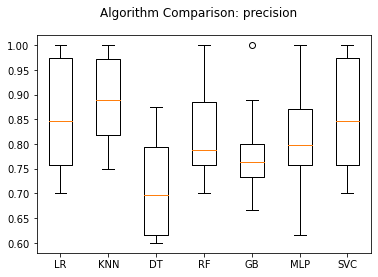

In [516]:
from sklearn.model_selection import cross_validate, KFold, learning_curve,  cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

models = []
models.append(('LR', LogisticRegression(random_state = 13))) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state = 13))) 
models.append(('RF', RandomForestClassifier(random_state = 13)))
models.append(('GB', GradientBoostingClassifier(random_state = 13))) 
models.append(('MLP', MLPClassifier(max_iter = 1000, random_state = 13)))
models.append(('SVC', LinearSVC()))

scoring = ['accuracy','recall','precision']
for s in scoring: 
    print(s)
    results = []
    names = []
    for i, j in models:
        kfold = KFold(n_splits=10, shuffle = True, random_state=13)
        cv_results = cross_val_score(j, X_train, y_train, cv=kfold, scoring=s)
        results.append(cv_results)
        names.append(i)
        msg = "%s: %f (%f)" % (i, cv_results.mean(), cv_results.std())
        print(msg)
    
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: ' + s)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

**Compare Models Individually**

Base models can be compared individually using the metrics: accuracy, precision, recall, and f1 score to help select the optimal model to further fine tune.

In [502]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

def model_report(y_test, y_test_pred):
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall: ', recall)
    print('f1 score: ', f1)

    print("\nClassification report:")
    print(classification_report(y_test, y_test_pred))
    skplt.metrics.plot_confusion_matrix(y_test, y_test_pred)

accuracy:  0.8241758241758241
precision:  0.8421052631578947
recall:  0.7619047619047619
f1 score:  0.8

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        49
           1       0.84      0.76      0.80        42

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91



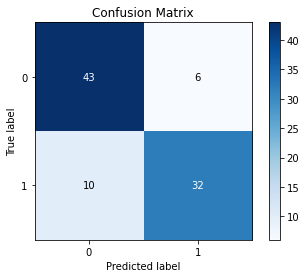

In [503]:
#LOGISTIC REGRESSION
logreg = LogisticRegression(random_state = 13)
model = logreg.fit(X_train,y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

accuracy:  0.8241758241758241
precision:  0.782608695652174
recall:  0.8571428571428571
f1 score:  0.8181818181818182

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        49
           1       0.78      0.86      0.82        42

    accuracy                           0.82        91
   macro avg       0.82      0.83      0.82        91
weighted avg       0.83      0.82      0.82        91



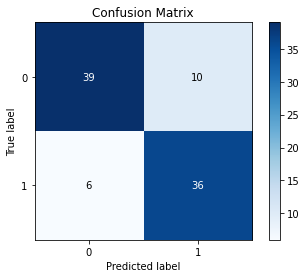

In [504]:
knn = KNeighborsClassifier()
model = knn.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

accuracy:  0.6703296703296703
precision:  0.6304347826086957
recall:  0.6904761904761905
f1 score:  0.6590909090909092

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68        49
           1       0.63      0.69      0.66        42

    accuracy                           0.67        91
   macro avg       0.67      0.67      0.67        91
weighted avg       0.67      0.67      0.67        91



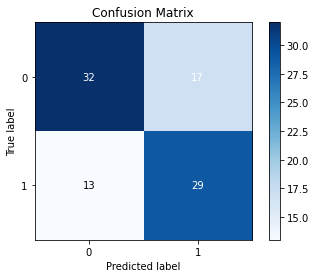

In [505]:
#DECISION TREE 
decisiontree = DecisionTreeClassifier(random_state = 13)
model = decisiontree.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

accuracy:  0.8131868131868132
precision:  0.8205128205128205
recall:  0.7619047619047619
f1 score:  0.7901234567901233

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        49
           1       0.82      0.76      0.79        42

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91



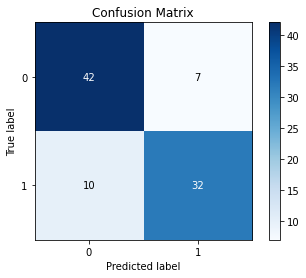

In [506]:
#RANDOM FOREST
randomforest = RandomForestClassifier(random_state = 13)
model = randomforest.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

accuracy:  0.7912087912087912
precision:  0.7674418604651163
recall:  0.7857142857142857
f1 score:  0.7764705882352941

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80        49
           1       0.77      0.79      0.78        42

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91



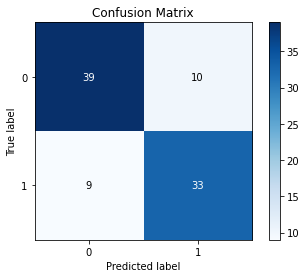

In [507]:
#GRADIENT BOOST 
gradientboost = GradientBoostingClassifier(random_state = 13)
model = gradientboost.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

accuracy:  0.7912087912087912
precision:  0.7555555555555555
recall:  0.8095238095238095
f1 score:  0.7816091954022989

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        49
           1       0.76      0.81      0.78        42

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91



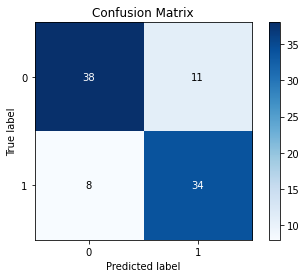

In [508]:
#MLP CLASSIFIER 
mlp = MLPClassifier(random_state =13, max_iter = 1000)
model = mlp.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

accuracy:  0.8241758241758241
precision:  0.8421052631578947
recall:  0.7619047619047619
f1 score:  0.8

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        49
           1       0.84      0.76      0.80        42

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91



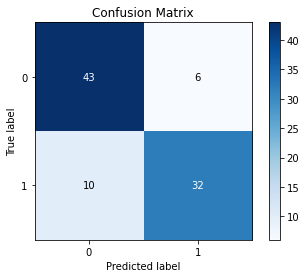

In [509]:
#SUPPORT VECTOR CLASSIFIER 
SVC = LinearSVC(random_state = 13)
model = SVC.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)

In [510]:
model_names = ['Logistic Regression','K Nearest Neighbors','Decision Tree','Random Forest','Gradient Boost','Multilayer Perceptron','Support Vector Classifier']

model_comparisons = pd.DataFrame(list(zip(model_names, accuracy_list, precision_list, recall_list, f1_list)), 
                      columns = ['Models','Accuracy','Precision','Recall', 'F1']).style.background_gradient(cmap='Blues')
model_comparisons

,Models,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.824176,0.842105,0.761905,0.800000
1,K Nearest Neighbors,0.824176,0.782609,0.857143,0.818182
2,Decision Tree,0.670330,0.630435,0.690476,0.659091
3,Random Forest,0.813187,0.820513,0.761905,0.790123
4,Gradient Boost,0.791209,0.767442,0.785714,0.776471
5,Multilayer Perceptron,0.791209,0.755556,0.809524,0.781609
6,Support Vector Classifier,0.824176,0.842105,0.761905,0.800000


## 7. Model Tuning 

Overall, the KNN algorithm performs the best with the test dataset. Therefore, we further optimize the KNN.

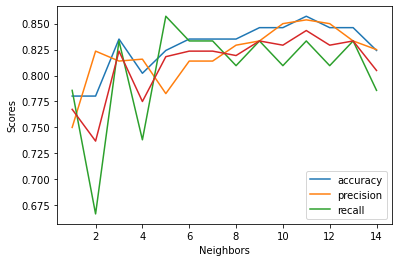

In [562]:
scores = {}
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
neighbors = [i for i in range(1,15)]

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    scores[i] = accuracy_score(y_test,y_test_pred)
    accuracy_list.append(accuracy_score(y_test,y_test_pred))
    precision_list.append(precision_score(y_test,y_test_pred))
    recall_list.append(recall_score(y_test,y_test_pred))
    f1_list.append(f1_score(y_test,y_test_pred))

plt.plot(neighbors, accuracy_list, label = 'accuracy')
plt.plot(neighbors, precision_list, label = 'precision')
plt.plot(neighbors, recall_list, label = 'recall')
plt.plot(neighbors, f1_list)

    
plt.xlabel("Neighbors")
plt.ylabel("Scores")
plt.legend(loc="lower right")

In [563]:
pd.DataFrame(list(zip(neighbors, accuracy_list, precision_list, recall_list, f1_list)), columns = ['Neighbors','Accuracy','Precision','Recall', 'F1']).style.background_gradient(cmap='Blues')

,Neighbors,Accuracy,Precision,Recall,F1
0,1,0.780220,0.750000,0.785714,0.767442
1,2,0.780220,0.823529,0.666667,0.736842
2,3,0.835165,0.813953,0.833333,0.823529
3,4,0.802198,0.815789,0.738095,0.775000
4,5,0.824176,0.782609,0.857143,0.818182
5,6,0.835165,0.813953,0.833333,0.823529
6,7,0.835165,0.813953,0.833333,0.823529
7,8,0.835165,0.829268,0.809524,0.819277
8,9,0.846154,0.833333,0.833333,0.833333
9,10,0.846154,0.850000,0.809524,0.829268


## 8. Final Model

Using KNN, 10 neighbors results in the highest classification accuracy, precision, recall, and f1-scores. Since KNN has no feature importances attribute, we do not know which variables were most important for this prediction.

accuracy:  0.8571428571428571
precision:  0.8536585365853658
recall:  0.8333333333333334
f1 score:  0.8433734939759037

Classification report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        49
           1       0.85      0.83      0.84        42

    accuracy                           0.86        91
   macro avg       0.86      0.86      0.86        91
weighted avg       0.86      0.86      0.86        91



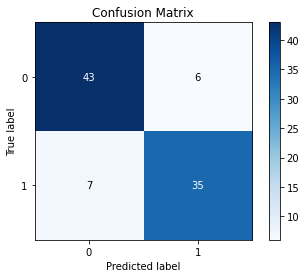

In [564]:
knn = KNeighborsClassifier(n_neighbors = 11) 
model = knn.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

model_report(y_test, y_test_pred)